In [1]:
import pandas as pd
from PIL import Image #pip install pillow
import numpy
from numpy import array
import matplotlib.pyplot as plt #pip install matplotlib
import seaborn as sb #pip install seaborn
from scipy.interpolate import griddata

In [2]:
class ArpesUFMG:
    def __init__(self, msg='Job Done!'):
        self.msg = msg      
    
    def put_axes(self, image_path, resize=False, w=500, h=500, E_i=20.675, E_f=21.625, Chi_i=-10, Chi_f=10):  
        print('putting axes...')  
        a,b = E_f, E_i  #Energy Window - ERange[eV]
        c,d = Chi_i, Chi_f #chi (Accepted Angle) - aRange[deg]        
        img = Image.open(image_path).rotate(90, expand=True)
        if resize:
            img.thumbnail((w,h), Image.ANTIALIAS)
        m,n = img.size
        if resize:
            print(f'New Size: {m} x {n}')
        else:
            print(f'Original Size: {m} x {n}')
        df = array(img)
        df = pd.DataFrame(df)
        E = numpy.linspace(a,b,n)
        E = numpy.round(E,4)
        df['Energy (eV)']=E
        df.set_index('Energy (eV)', inplace=True)
        chi=numpy.round(numpy.linspace(c,d,m),3) #Acceptance angle array in dg    
        df.columns=chi
        df.interpolate(method='polynomial',order=3,inplace=True)
        fig = plt.figure(figsize=(8,8))
        sb.heatmap(df,cmap='gist_yarg_r')
        plt.xlabel('Accepted Angle (dg)')
        #plt.show()
        fig.savefig('ARPES_R90_new.png')
        print(self.msg)
        return df, m, n
    
    def k_warp(self, df,  m, n, phi=0, verbose=False):
        print('k warping...')
        worksheet = []
        for i in range(0,m):
            for j in range(0,n):
                chi2=float(df.columns[i])
                E2=float(df.index[j]) 
                count2=float(df.values[j][i])      
                kx=numpy.round(float(0.512*E2**(1/2)*numpy.sin(chi2*numpy.pi/180)*numpy.cos(phi*numpy.pi/180)),3)
                ky=numpy.round(float(0.512*E2**(1/2)*numpy.sin(chi2*numpy.pi/180)),3)*round(float(numpy.sin(phi*numpy.pi/180)),3)
                if chi2<0:
                    kp=-(kx**2+ky**2)**(1/2)
                elif chi2>=0:
                    kp=(kx**2+ky**2)**(1/2)
                worksheet.append((chi2,phi,kx,ky,kp,E2,count2))
                if verbose:
                    print(chi2,phi,kx,ky,kp,E2,count2)
        da=pd.DataFrame(worksheet,columns=['Chi','Phi','kx','ky','kp','Energy','Counts'])
        da.sort_values(by=['kp'],inplace=True)
        da.interpolate(method='polynomial',order=3,inplace=True)
        da.to_csv('Warped_new.dat', index=False)
        print(self.msg)
        return da
    
    def plot_k_warp(self, da):
        print('saving k warped file...')
        #from scipy.ndimage.filters import gaussian_filter
        x = (numpy.asarray(da['kp'])+0.05 ) #Deslocate kp
        y = (numpy.asarray(da['Energy'])-0) #Deslocate Energy
        z = (numpy.asarray(da['Counts'])**(1))# Change the expoent to best contrast
        fig = plt.figure(figsize=(5,8)); #Fig. Size
        plt.xlim(-0.3,0.3) #Kp Limits
        plt.ylim(20.675,21.625) # Energy Limits
        plt.xlabel('Parallel $\t{Momentum}$ ($\AA^{-1}$)') #kp Label (using LaTeX)
        plt.ylabel('Energy (eV)') #Energy label
        plt.tricontourf(x, y, z,100)
        #plt.show();
        fig.savefig('K-WARPED_new.png');
        print(self.msg);
        return None
    
    # After the K-WARP
    def get_mdc_curves(self, E_i=20.87, E_f=21.24, line_spacing=30, dE=0.01):        
        curves_mdc = {}
        v = 1
        df = pd.read_csv('Warped_new.dat')
        range_E = numpy.arange(E_i,E_f,dE)
        ax1 = plt.figure(figsize=(15,10))
        #ndf = df.copy()

        for energy in range_E:
            v +=1           
            x = df[(df['Energy'] >= energy) & (df['Energy'] <= energy + dE)]['kp']
            y = df[(df['Energy'] >= energy) & (df['Energy'] <= energy + dE)]['Counts']
            z = df[(df['Energy'] >= energy) & (df['Energy'] <= energy + dE)]['Energy'].mean()               
            curves_mdc.update({ round(z,4):[array(x), array(y)]})
            plt.plot(x,y + line_spacing*v**(0.8))
        print(f'{len(curves_mdc)} of {v} curves extracted!')
        print(self.msg);
        return curves_mdc
    
    def get_edc_curves(self, k_i=-0.3, k_f=0.3, line_spacing=0.12, dk=0.01):
        v = 1
        df = pd.read_csv('Warped_new.dat')
        range_k = numpy.arange(k_i,k_f,dk)
        curves_edc = {}
        ax1 = plt.figure(figsize=(15,10))
        for k in range_k:
            v += 1
            if k < 0:
                x = df[(df['kp'] >= k-dk) & (df['kp'] <= k)].sort_values(by=['Energy'])['Energy']
                y = df[(df['kp'] >= k-dk) & (df['kp'] <= k)].sort_values(by=['Energy'])['Counts']
                z = df[(df['kp'] >= k-dk) & (df['kp'] <= k)].sort_values(by=['Energy'])['kp'].mean()
                curves_edc.update({ round(z,4):[array(x), array(y)]})
                plt.plot(x,y + line_spacing*abs(v)**2)
            else:
                x = df[(df['kp'] >= k) & (df['kp'] <= k + dk)].sort_values(by=['Energy'])['Energy']
                y = df[(df['kp'] >= k) & (df['kp'] <= k + dk)].sort_values(by=['Energy'])['Counts']
                z = df[(df['kp'] >= k) & (df['kp'] <= k + dk)].sort_values(by=['Energy'])['kp'].mean()
                curves_edc.update({ round(z,4):[array(x), array(y)]})
                plt.plot(x,y + line_spacing*abs(v)**2)
        print(f'{len(curves_edc)} of {v} curves extracted!')
        print(self.msg);
        return curves_edc

putting axes...
New Size: 147 x 200
Job Done!


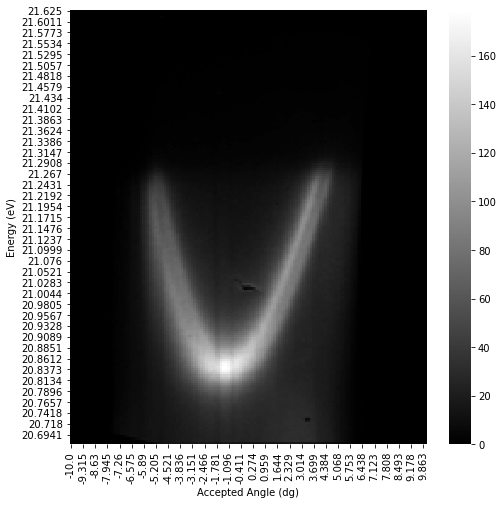

In [25]:
au111 = ArpesUFMG()
df, m, n = au111.put_axes('ARPES.png', resize =True, w=200,h=200)

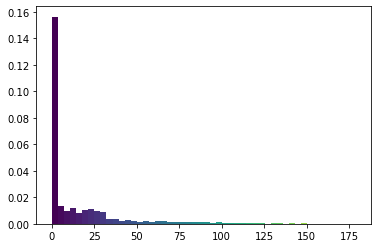

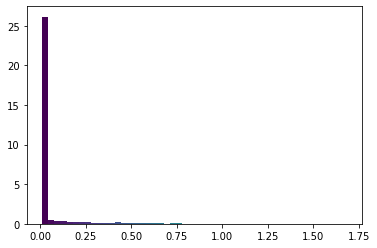

<AxesSubplot:>

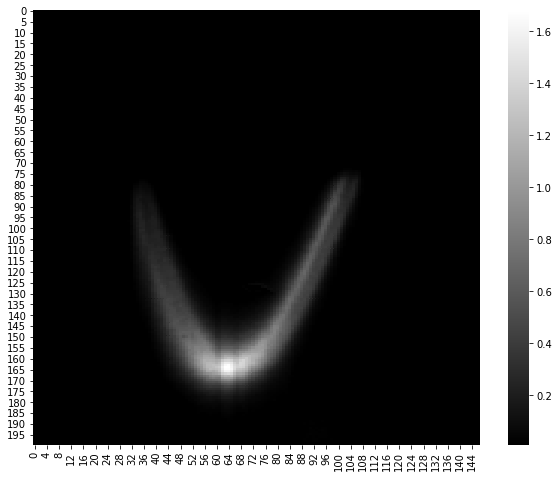

In [41]:

arr = numpy.asarray(df)


from matplotlib import cm

def normalize(arr):
    arr_min = numpy.min(arr)
    return (arr-arr_min)/(numpy.max(arr)-arr_min)

def show_histogram(values):
    n, bins, patches = plt.hist(values.reshape(-1), 50, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for c, p in zip(normalize(bin_centers), patches):
        plt.setp(p, 'facecolor', cm.viridis(c))

    plt.show()
    
show_histogram(arr)

def scale_by(arr, fac):
    mean = numpy.mean(arr)
    return (arr-mean)*fac + mean
transformed = numpy.clip(scale_by(numpy.clip(normalize(arr)-0.1, 0, 5)**1.5, 2), 0.01, 3)
show_histogram(transformed)
plt.figure(figsize=(10,8))
sns.heatmap(transformed, cmap='gray')

In [31]:
da = au111.k_warp(df,  m, n, phi=0, verbose=False)

k warping...
Job Done!


saving k warped file...
Job Done!


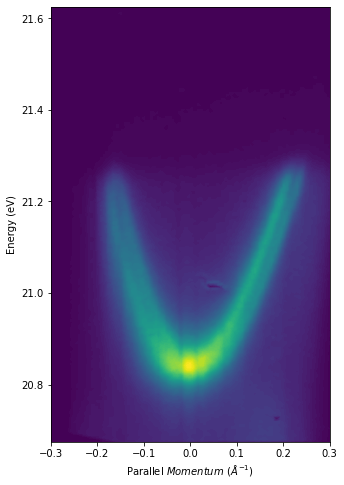

In [32]:
au111.plot_k_warp(da)

81 of 82 curves extracted!
Job Done!


dict_keys([20.9041, 20.9089, 20.9137, 20.9185, 20.9232, 20.928, 20.9328, 20.9376, 20.9423, 20.9471, 20.9519, 20.9567, 20.9614, 20.9662, 20.971, 20.9758, 20.9805, 20.9853, 20.9925, 20.9996, 21.0044, 21.0092, 21.0139, 21.0187, 21.0235, 21.0283, 21.033, 21.0378, 21.0426, 21.0474, 21.0521, 21.0569, 21.0617, 21.0665, 21.0712, 21.076, 21.0808, 21.0856, 21.0903, 21.0975, 21.1046, 21.1094, 21.1142, 21.119, 21.1237, 21.1285, 21.1333, 21.1381, 21.1428, 21.1476, 21.1524, 21.1572, 21.1619, 21.1667, 21.1715, 21.1763, 21.181, 21.1858, 21.1906, 21.1954, 21.2025, 21.2097, 21.2144, 21.2192, 21.224, 21.2288, 21.2335, 21.2383, 21.2431, 21.2479, 21.2526, 21.2574, 21.2622, 21.267, 21.2717, 21.2765, 21.2813, 21.2861, 21.2908, 21.2956, 21.3004])

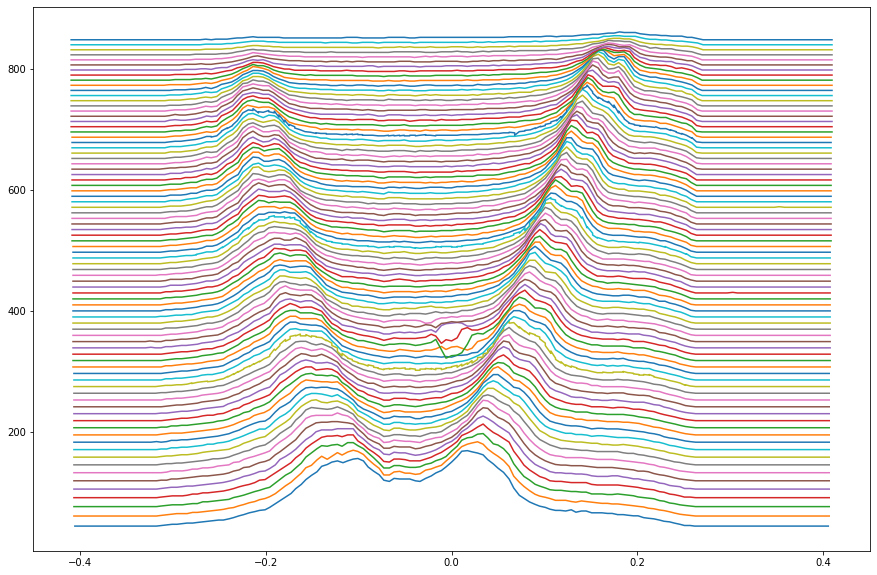

In [35]:
curves_mdc = au111.get_mdc_curves(E_i=20.9, E_f=21.3,line_spacing=25, dE=0.005)
curves_mdc.keys()

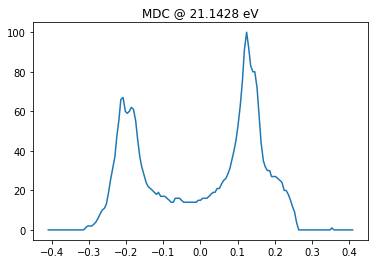

In [37]:
#MDC example at 21.0856 eV
#curves_mdc
df_curves_mdc = pd.DataFrame(curves_mdc).T;
plt.title('MDC @ 21.1428 eV');
plt.plot(df_curves_mdc.loc[21.1428][0],df_curves_mdc.loc[21.1428][1]);

In [ ]:
#tentativa filtro

img = Image.open('ARPES.png').rotate(90, expand=True)

df_raw = pd.DataFrame(array(img))

from scipy import ndimage as nd
values = nd.filters.laplace(df_raw.copy().values,cval=10)
plt.imshow(values)

df_trans = df_raw.copy()
df_trans2 = df_raw.copy()

for x in range(1392):
    for y in range(0,1023):
        df_trans.values[x][y] = df_trans.values[x][y] + values[x][y]
        df_trans2.values[x][y] = df_trans2.values[x][y] + (values[x][y+1] + values[x][y-1] - 2*values[x][y])        
        


In [ ]:
# Filtro
fig, ax = plt.subplots(1,3,figsize=(15,10))
ax1 = sb.heatmap(df_raw, cbar=False, ax=ax[0]) #Raw
ax2 = sb.heatmap(df_trans,cbar=False,  ax=ax[1]) #Second Derivative
ax3 = sb.heatmap(df_trans2,cbar=False,  ax=ax[2]) #Second derivative of second derivative

101 of 102 curves extracted!
Job Done!


dict_keys([-0.4029, -0.3974, -0.3913, -0.3849, -0.3788, -0.3729, -0.367, -0.3612, -0.3552, -0.3488, -0.3426, -0.3365, -0.331, -0.3249, -0.3182, -0.3123, -0.3064, -0.3005, -0.2945, -0.2886, -0.2826, -0.2766, -0.2706, -0.2647, -0.2586, -0.2525, -0.2465, -0.2405, -0.2346, -0.2286, -0.2225, -0.2165, -0.2104, -0.2044, -0.1982, -0.1921, -0.1859, -0.18, -0.1744, -0.1687, -0.1632, -0.1574, -0.1514, -0.1452, -0.1389, -0.1327, -0.1264, -0.12, -0.1136, -0.1073, -0.1013, -0.0957, -0.0901, -0.0845, -0.0788, -0.0732, -0.0675, -0.0619, -0.0563, -0.0504, -0.0435, -0.036, -0.0286, -0.0225, -0.017, -0.011, -0.006, 0.006, 0.011, 0.017, 0.0225, 0.028, 0.0339, 0.0394, 0.0463, 0.0535, 0.0605, 0.0672, 0.0732, 0.0788, 0.0845, 0.0901, 0.0957, 0.1013, 0.1069, 0.1126, 0.1183, 0.1246, 0.1309, 0.1372, 0.1435, 0.1497, 0.1559, 0.1621, 0.1682, 0.1742, 0.18, 0.1856, 0.1912, 0.1971, 0.2032])

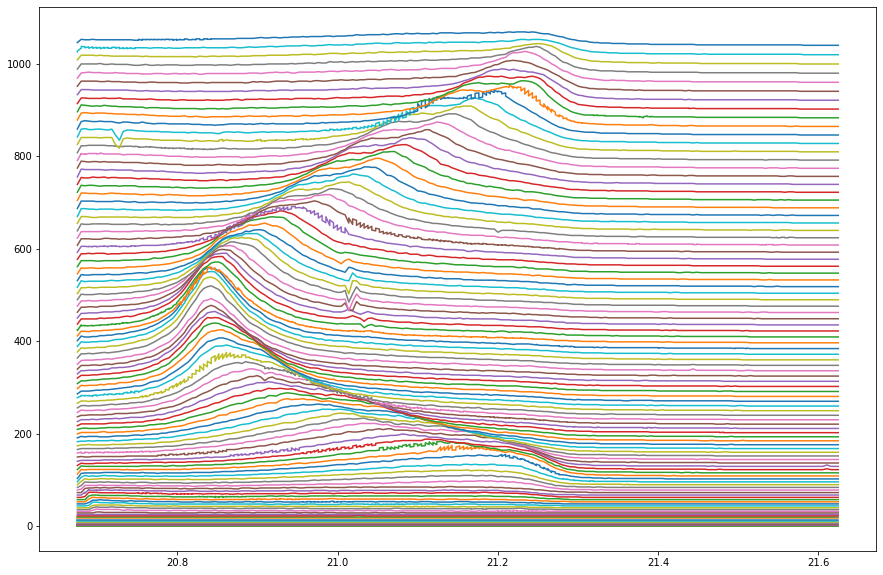

In [38]:
curves_edc = au111.get_edc_curves(k_i=-0.4, k_f=0.2, line_spacing=0.1, dk=0.006)
curves_edc.keys()

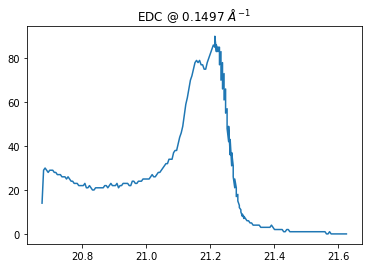

In [42]:
#EDC Example at kp = 0.1497
plt.title('EDC @ 0.1497 $\AA^{-1}$');
plt.plot(curves_edc[0.1497][0],curves_edc[0.1497][1]);
